# Recursive Estimation

In the previous notebook you were presented with all the noisy measurements prior to estimating $\hat{x}$. In this notebook, measurements will be received one at a time. You'll update $\hat{x}$ on each measurement.

Once again, the vehicle is not moving - the state, $x$, is constant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from matplotlib.patches import Ellipse
from matplotlib.patches import Arrow

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

Plotting code.

In [3]:
def create_ellipse(mu, angle, width, height):
    # angle is plotted such that it starts from 180 and goes
    # clockwise instead of from 0 degrees and goes counter-clockwise
    # so 135 degrees -> 45 degrees
    return Ellipse(xy=mu, width=width*2, height=height*2, angle=angle,
                      facecolor='none', linestyle='dotted', edgecolor='r')

def plot_ellipse(mu, sigma):  
    (w, v) = LA.eig(sigma)
    angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
    
    ax = plt.gca()
    ax.set_xlim(mu[0] + -1.3, mu[0] + 1.3)
    ax.set_ylim(mu[1] + -1.3, mu[1] + 1.3)
    
    ellipse = create_ellipse(mu, angle, w[0], w[1])
    ellipse.set_edgecolor('k')
    ax.add_patch(ellipse)
    plt.plot(mu[0], mu[1], 'ro')

In [4]:
# Constants

# number of samples
n_samples = 1000

# ground truth state
x = np.array([-0.85, 0.25]).reshape(2, 1)

# state -> measurement map
H = np.array([1, -1]).reshape(1, 2)

# noise
R = np.eye(1) * 0.01

In [5]:
R

array([[0.01]])

We haven't sampled a measurement as of yet so at the moment let's assume we have:

In [6]:
x_hat0 = np.array([0, 0]).reshape(-1, 1)
Q0 = np.eye(len(x_hat0))

`plot_ellipse` will plot an ellipse given `mu` and `sigma`. The significance of the plot being anything inside the ellipse is a possible value of $\hat{x}$. Initially this will look like a circle.

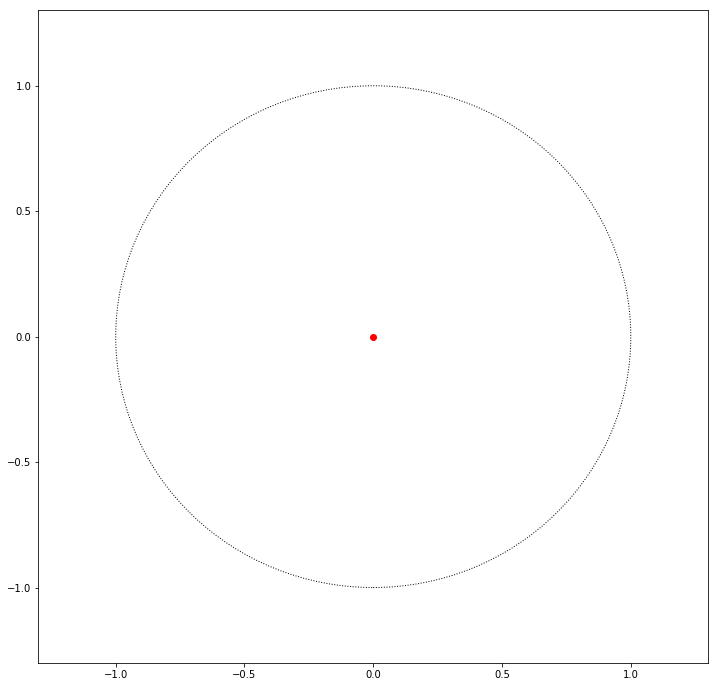

In [7]:
plot_ellipse(x_hat0, Q0)

Ideally, by the end of the sampling process the plot should look like a very small ellipse, centered around the ground truth state $x$.

Recall the update functions for $Q$ and $\hat{x}$.

$
Q_{t+1} = (Q_{t}^{-1} + H^T R^{-1} H)^{-1}\\
\hat{x}_{t+1} = \hat{x_t} + Q_{t+1} H^{T} R^{-1} (\tilde{y_t} - H \hat{x_t})
$

Don't be too concerned if your final $\hat{x}$ value isn't the same as $x$. We'll go over why this might be in a second.

If `H @ x` is ~= `H @ x_hat` your solution is correct.

In [12]:
def recursive_estimation(x_hat0, Q0, n_samples):
    x_hat = np.copy(x_hat0)
    Q = np.copy(Q0)
    
    for _ in range(n_samples):
        # TODO: sample a measurement
        y_obs = H @ x + np.random.multivariate_normal([0.], R)
    
        # TODO: update Q and x_hat
        Q = LA.pinv( LA.pinv(Q) + H.T @ LA.pinv(R) @ H)
        x_hat = x_hat + Q @ H.T @ LA.pinv(R) @ (y_obs - H @ x_hat) 
        
    return x_hat, Q

In [17]:
x_hat, Q = recursive_estimation(x_hat0, Q0, n_samples)
    
print("x =", x.squeeze())
print("x̂ =", x_hat.squeeze())
print("Hx =", H @ x.squeeze())
print("Hx̂ =", H @ x_hat.squeeze())
print(Q)

x = [-0.85  0.25]
x̂ = [-0.54921621  0.54921621]
Hx = [-1.1]
Hx̂ = [-1.09843243]
[[0.5000025 0.4999975]
 [0.4999975 0.5000025]]


Let's plot the ellipse again.

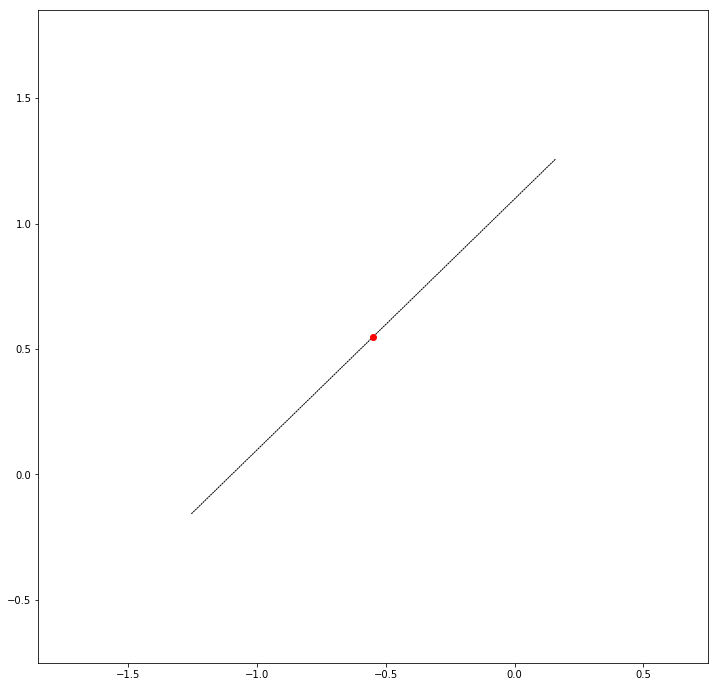

In [14]:
plot_ellipse(x_hat, Q)

Hmmm, not quite what we wanted, this is essentially a line. So what does this mean?

Any state value, $z$, chosen from the line will produce equivalent measurements to the ground truth state. That is, `H @ z` ~= `H @ x`.

If we look at `H` as a function then there are multiple inputs which map to the same output. If we're trying to figure out the input given output values, we won't necessarily come up with the correct input. Additionally, once we "arrive" at an input which produces the appropriate outputs then $\hat{x}$, $\hat{x}_{t+1} \approx \hat{x}_{t}$ since $(\tilde{y_t} - H \hat{x_t}) \approx 0$.

Update function for reference:

$
\hat{x}_{t+1} = \hat{x_t} + Q_{t+1} H^{T} R^{-1} (\tilde{y_t} - H \hat{x_t})
$

Let's look at this in more detail empirically. To find other inputs along the line we'll need the angle of the ellipse. We can compute this with the eigenvectors of $Q$.

In [15]:
(w, v) = LA.eig(Q)
# sync angle with plotted ellipse
angle = np.pi - np.arctan2(v[1, 0], v[0, 0])
print("eigen values", w)
print("eigen vectors", v)
print("angle", np.degrees(angle))

eigen values [4.999975e-06 1.000000e+00]
eigen vectors [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
angle 44.99999999999921


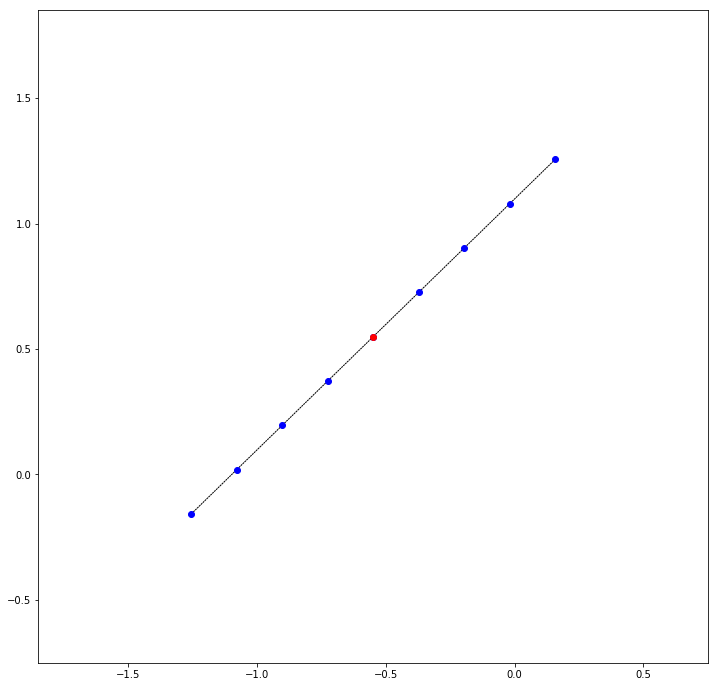

In [16]:
inputs = []
outputs = []
dt = 0.25

for v in np.arange(-1, 1+dt, dt):
    s = np.array([x_hat[0] + np.cos(angle) * v, x_hat[1] + np.sin(angle) * v])
    outputs.append(H @ s)
    inputs.append(s.reshape(1, -1))
inputs = np.array(inputs).squeeze()

plt.plot(inputs[:, 0], inputs[:, 1], 'bo')
# plot x_hat
plot_ellipse(x_hat, Q)

These outputs should be similar.

In [12]:
print(outputs)

[array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]]), array([[-1.10071217]])]


[Solution](./Recursive-Estimation-Solution.ipynb)